In [36]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
import random

In [30]:
# Data Augmentation Functions for Fake Samples
def augment_audio(waveform, sr):
    # Random pitch shift
    if random.random() < 0.5:
        waveform = librosa.effects.pitch_shift(waveform, sr=sr, n_steps=random.uniform(-2, 2))
    # Random time stretch
    if random.random() < 0.5:
        stretch = random.uniform(0.8, 1.2)
        waveform = librosa.effects.time_stretch(waveform, rate=stretch)
    return waveform

# Block 1: Updated TinyAudioNet
class TinyAudioNet(nn.Module):
    def __init__(self, n_mfcc=60, time_steps=32):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(n_mfcc, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # Global average pooling
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [31]:
# Block 2: Updated Dataset with Augmentation and Extended max_len
class RawAudioDataset(Dataset):
    def __init__(self, real_files, fake_files, sr=16000, max_len=160000, augment=False):
        self.real_files = real_files
        self.fake_files = fake_files
        self.all_files = real_files + fake_files
        self.labels = [0] * len(real_files) + [1] * len(fake_files)
        self.sr = sr
        self.max_len = max_len
        self.augment = augment

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        file = self.all_files[idx]
        label = self.labels[idx]
        waveform, _ = librosa.load(file, sr=self.sr, mono=True)

        # Apply augmentation only to fake samples
        if self.augment and label == 1:
            waveform = augment_audio(waveform, self.sr)

        if len(waveform) > self.max_len:
            waveform = waveform[:self.max_len]
        else:
            waveform = np.pad(waveform, (0, max(0, self.max_len - len(waveform))))

        mfcc = librosa.feature.mfcc(y=waveform, sr=self.sr, n_mfcc=60)
        mfcc = mfcc[:, :32]
        if mfcc.shape[1] < 32:
            mfcc = np.pad(mfcc, ((0, 0), (0, 32 - mfcc.shape[1])))

        mfcc = torch.FloatTensor(mfcc)  # (60, 32)
        return mfcc, torch.tensor(label, dtype=torch.long)


In [41]:
# Block 3: Training Function

def train_model(model, train_loader, dev_loader, epochs=50, lr=0.001):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)

    class_weights = torch.tensor([1.0, 1.2], device=device)  # Slight bias toward Fake
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_acc = 0
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for waveforms, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            waveforms, labels = waveforms.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(waveforms)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_loss = train_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        correct, total = 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for waveforms, labels in dev_loader:
                waveforms, labels = waveforms.to(device), labels.to(device)
                outputs = model(waveforms)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss: {avg_loss:.4f} | Val Acc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "TinyAudioNet_best.pth")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot Learning Curves
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label="Validation Accuracy", color='orange')
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 1: Train Loss: 0.3205 | Val Acc: 81.38%


Epoch 2: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 2: Train Loss: 0.1559 | Val Acc: 89.50%


Epoch 3: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


Epoch 3: Train Loss: 0.1257 | Val Acc: 92.38%


Epoch 4: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


Epoch 4: Train Loss: 0.1244 | Val Acc: 92.00%


Epoch 5: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 5: Train Loss: 0.1007 | Val Acc: 92.25%


Epoch 6: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Epoch 6: Train Loss: 0.0967 | Val Acc: 90.62%


Epoch 7: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


Epoch 7: Train Loss: 0.0864 | Val Acc: 91.25%


Epoch 8: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 8: Train Loss: 0.0766 | Val Acc: 86.62%


Epoch 9: 100%|██████████| 100/100 [01:09<00:00,  1.45it/s]


Epoch 9: Train Loss: 0.0742 | Val Acc: 90.88%


Epoch 10: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


Epoch 10: Train Loss: 0.0726 | Val Acc: 94.25%


Epoch 11: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


Epoch 11: Train Loss: 0.0649 | Val Acc: 93.88%


Epoch 12: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Epoch 12: Train Loss: 0.0626 | Val Acc: 92.75%


Epoch 13: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 13: Train Loss: 0.0542 | Val Acc: 92.12%


Epoch 14: 100%|██████████| 100/100 [01:09<00:00,  1.43it/s]


Epoch 14: Train Loss: 0.0640 | Val Acc: 90.88%


Epoch 15: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 15: Train Loss: 0.0473 | Val Acc: 94.25%


Epoch 16: 100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


Epoch 16: Train Loss: 0.0539 | Val Acc: 94.00%


Epoch 17: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Epoch 17: Train Loss: 0.0568 | Val Acc: 93.75%


Epoch 18: 100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


Epoch 18: Train Loss: 0.0425 | Val Acc: 94.62%


Epoch 19: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


Epoch 19: Train Loss: 0.0482 | Val Acc: 93.25%


Epoch 20: 100%|██████████| 100/100 [01:11<00:00,  1.41it/s]


Epoch 20: Train Loss: 0.0504 | Val Acc: 93.75%

Classification Report:
              precision    recall  f1-score   support

        Real       0.90      0.98      0.94       400
        Fake       0.98      0.89      0.93       400

    accuracy                           0.94       800
   macro avg       0.94      0.94      0.94       800
weighted avg       0.94      0.94      0.94       800



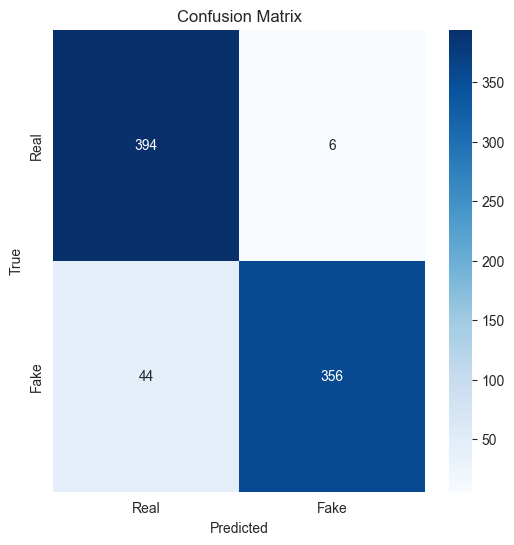

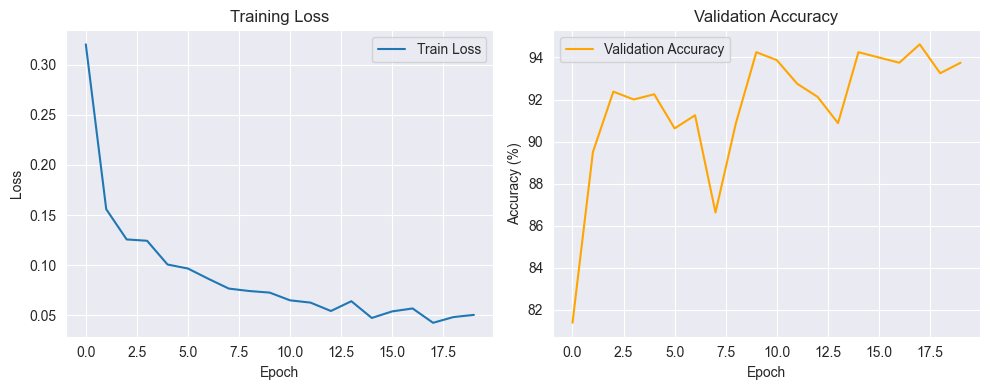

In [42]:
# Block 4: Main Runner with Stratified Split
if __name__ == "__main__":
    real_paths = [os.path.join("data/train/real", f) for f in os.listdir("data/train/real") if f.endswith(".flac")]
    fake_paths = [os.path.join("data/train/fake", f) for f in os.listdir("data/train/fake") if f.endswith(".flac")]

    # Stratified split
    all_paths = real_paths + fake_paths
    all_labels = [0]*len(real_paths) + [1]*len(fake_paths)
    train_paths, dev_paths, train_labels, dev_labels = train_test_split(all_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

    train_real = [p for p, l in zip(train_paths, train_labels) if l == 0]
    train_fake = [p for p, l in zip(train_paths, train_labels) if l == 1]
    dev_real = [p for p, l in zip(dev_paths, dev_labels) if l == 0]
    dev_fake = [p for p, l in zip(dev_paths, dev_labels) if l == 1]

    train_dataset = RawAudioDataset(train_real, train_fake, augment=True)
    dev_dataset = RawAudioDataset(dev_real, dev_fake, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

    model = TinyAudioNet(n_mfcc=60, time_steps=32)
    train_model(model, train_loader, dev_loader, epochs=20)
